In [1053]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

Prior: (naturalness)
$$prior(\boldsymbol{a}|M,R)=(\frac{1}{\sqrt{2\pi}R})^{M+1}exp(-\frac{\boldsymbol{a}^2}{2R^2})
$$

Likelihood:
$$
likelihood(D|\boldsymbol{a})\propto e^{-\frac{1}{2}\sum_{i}(\frac{y_i-f_i}{\sigma_i})^2}
$$

posterior:
$$
posterior(\boldsymbol{a}|D)\propto e^{-\frac{1}{2}(\sum_{i}(\frac{y_i-f_i}{\sigma_i})^2+\frac{\boldsymbol{a}^2}{R^2})}
$$



generate data from function $g(x)=(\frac{1}{2}+tan(\frac{\pi}{2}x))^2$(which is precise value)  
with relative error of each 'experimental points' being constant $c$  
the number of mesh (or $x$ points) $N$

In [1054]:
def g(x):
    return (0.5 + np.tan(np.pi * x / 2))**2

c=0.05
N=10

generate mesh $x$ within domain $D_2=[0,\frac{2}{\pi}]$, $N$ points  

In [1055]:
x=np.linspace(2/np.pi/N,2/np.pi,N)
print('x:')
print(x)
print('x*pi/2:')
print(x*np.pi/2)

x:
[0.06366198 0.12732395 0.19098593 0.25464791 0.31830989 0.38197186
 0.44563384 0.50929582 0.5729578  0.63661977]
x*pi/2:
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


eta is used to generate 'experiment data' (virtually), which follows a normal distribution, for each data point there is a corresponding $\sigma_{\eta_i}$    
$\sigma_{\eta}=1,\bar{\eta}=0$, $\eta \sim N(0,\sigma_\eta)$  
then generate 'data points' by $y(x_i)=g(x_i)(1+c\eta_i)$  
and $\sigma_i=cy(x_i)$

y:
[0.3658354  0.48412471 0.67460522 0.87881767 1.13958208 1.51199293
 1.73006721 2.31614077 3.38112775 3.99993461]
sigma:
[0.01829177 0.02420624 0.03373026 0.04394088 0.0569791  0.07559965
 0.08650336 0.11580704 0.16905639 0.19999673]


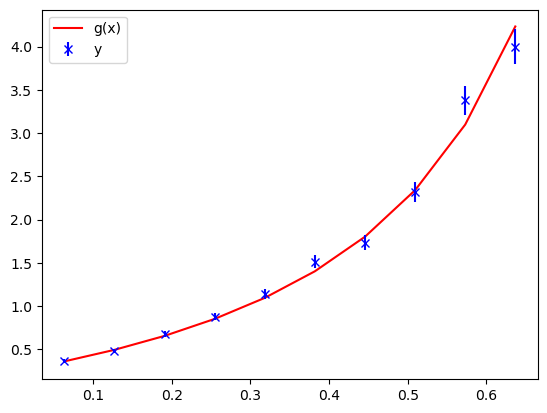

In [1056]:
sigma_eta=1
eta=np.random.normal(0,sigma_eta,N)
y=g(x)*(1+c*eta)
sigma=c*y
#-----------------------------------
print('y:')
print(y)
print('sigma:')
print(sigma)
#plt.plot(x,y,'gx-',label='yerrbar')
plt.plot(x,g(x),'r-',label='g(x)')
plt.errorbar(x,y,yerr=sigma,fmt='bx',label='y')
plt.legend()
plt.show()

order of polynominal $M$  
sample parameter($M+1$ rows, $N_{par}$ columns)  
$R$: standard deviation parameter in the prior

In [1057]:
M=5
R=5

define polynominal function  
chi square: $\chi^2=\sum_{i} \frac{(y_i-f_i)^2}{\sigma_i^2} $  
likelihood: $p(D|\alpha)\propto exp(-\frac{1}{2}\chi^2)$

In [1058]:
#def polynomial function
def polynomial(para,x):
    return np.polyval(para,x)

#def chi-square function
def chi_square(y, f, sigma):
    return np.sum(((y-f)**2)/sigma**2)

#def likelyhood function
def likelihood(y, f, sigma):
    chi_sq = chi_square(y, f, sigma)
    return np.exp(-0.5 * chi_sq)
    
#def log_posterior
def log_posterior(a, x, y, sigma, R):
    model = polynomial(a, x)  
    return -0.5 * (np.sum(a**2)/ R**2 + chi_square(y, model, sigma))

In [1059]:
nwalkers = 32   
#a = np.random.rand(nwalkers, M+1)
a = np.random.normal(0, R, (nwalkers, M+1))

In [1060]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, M+1, log_posterior, args=[x,y,sigma,R],a=4)
state = sampler.run_mcmc(a, 1000)
sampler.reset()
sampler.run_mcmc(state, 10000);


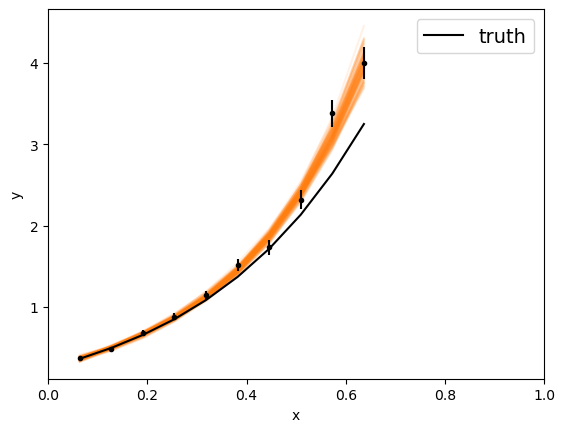

In [1061]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.polyval(sample,x), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=sigma, fmt=".k", capsize=0)
plt.plot(x, np.polyval([4.06,1.29,2.47,1.57,0.25],x), "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 1)
plt.xlabel("x")
plt.ylabel("y");

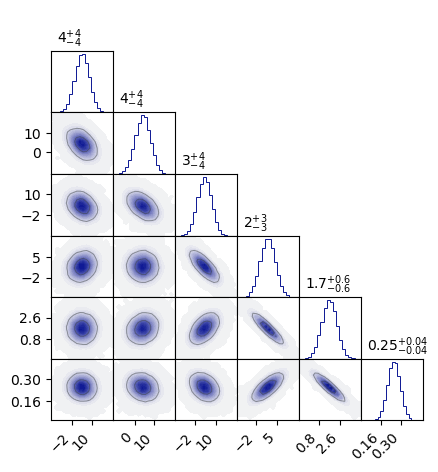

In [1062]:
import prettyplease
samples = sampler.get_chain(flat=True)
# plt.hist(samples[:,4], 100, color="k", histtype="step", density=True)
# plt.xlabel(r"$\theta$")
# plt.ylabel(r"$p(\theta|D)$")s
#plt.gca().set_yticks([]);
fig = prettyplease.corner(samples)
plt.show()  

In [1063]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.516
Mean autocorrelation time: 64.684 steps
